# Title I Allocations w/ DP ACS

In [1]:
from dp_policy.experiments import titlei_funding as funding, titlei_grid as test_params
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth
from dp_policy.titlei.utils import *
from dp_policy.titlei.thresholders import *
from dp_policy.titlei.evaluation import *
from dp_policy.experiments import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

saipe = get_inputs(2021)
sppe = get_sppe("../data/sppe18.xlsx")
print(saipe.shape)

plt.style.use('seaborn-deep')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
(13190, 24)


## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [3]:
sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

state    ppe abbrv
0         Alabama   9697    AL
1          Alaska  17726    AK
2  American Samoa    NaN    AS
3         Arizona   8296    AZ
4        Arkansas  10072    AR

Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [62]:
saipe.head()

State Postal Code                         Name  \
State FIPS Code District ID                                                  
1               1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               1                                  4547   
                1                                  4547   
                1                                  4547   
                1                                  4547   
                1                                  4547   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               1                                  861   
                1                                  861   
                1                                  861   
                1                                  861   
                1                                  861   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       

                               cv     LEAID  Sort C    State  \
State FIPS Code District ID                                    
1               1            0.42  100001.0     1.0  ALABAMA   
                1            0.42  100003.0     1.0  ALABAMA   
                1            0.42  100005.0     1.0  ALABAMA   
                1            0.42  100006.0     1.0  ALABAMA   
                1            0.42  100007.0     1.0  ALABAMA   

                             Basic Hold Harmless  ...  \
State FIPS Code District ID                       ...   
1               1                   6.145069e+04  ...   
                1                   2.085941e+04  ...   
                1                   8.205345e+05  ...   
                1                   1.319212e+06  ...   
                1                   6.089449e+05  ...   

                             Hold Harmless Percentage  Resident Pop.  \
State FIPS Code District ID                                            
1               1                            1.505202         4547.0   
                1                            0.850000         2482.0   
                1                            0.900000        22051.0   
                1                            0.901848        49087.0   
                1                            0.936605        83044.0   

                             Total Formula Count  5-17 Pop.  Percent Formula  \
State FIPS Code District ID                                                    
1               1                          135.0      861.0         0.156794   
                1                           27.0      243.0         0.111111   
                1                          971.

In [63]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

104.63089683773975

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

Finally, the main method for computing estimates, then grant amounts.

-- WARNING: dropping some balances from total budget --
Puerto Rico 413911155.7939328
County balances 728460.8149536257
Part D Subpart 2 98548579.79236995
15836763981.599205


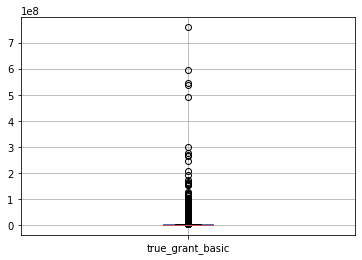

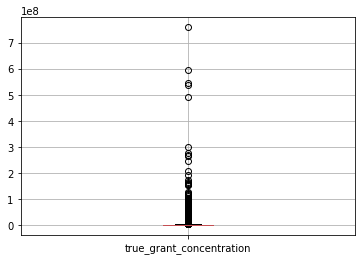

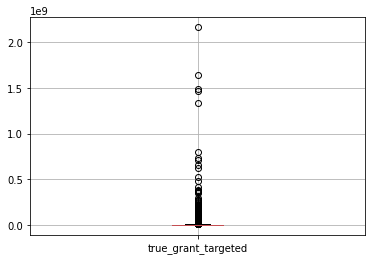

In [236]:
# Test with ground truth mechanism
saipe = get_inputs(2021)
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(), get_sppe("../data/sppe18.xlsx"))
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Ground Truth Comparison
How close are our allocation estimates to the actual allocations from 2019? Note that we only have 2020's allocations, when really we need 2021's allocations, which will use the 2019 ACS data (see [here](https://www.nd.gov/dpi/sites/www/files/documents/Educational%20Equity%20%26%20Support/Title%20I/USED%20Census%202019%20Memo.pdf)). But historically the numbers are close.

-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
total
Average error -7.060823158570724e-11
RMSE 267898.8913773343 (average alloc is 1200349.4811968347 )


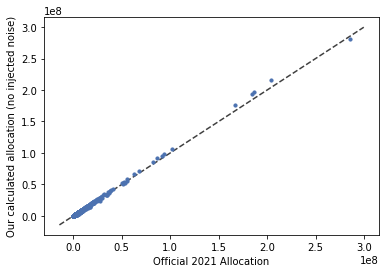

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     2.172240e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                8.466005e+07                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     1.844383e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       1.844383e+08 -1.112577e+07  

[1 rows x 67 columns]

basic
Average error -1.0450018274684671e-11
RMSE 93867.8964035751 (average alloc is 1200349.4811968347 )


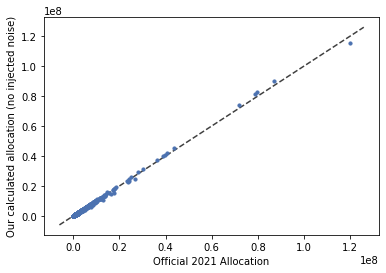

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     3.247885e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.304930e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.794623e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.794623e+08 -2.907847e+06  

[1 rows x 67 columns]

concentration
Average error -1.5745635643612715e-11
RMSE 85392.67792116926 (average alloc is 1200349.4811968347 )


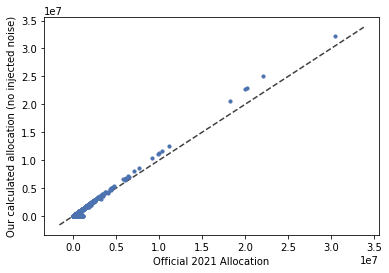

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     3.070087e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.219005e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.623403e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.623403e+08 -2.931902e+06  

[1 rows x 67 columns]

targeted
Average error -4.6036566993881124e-11
RMSE 123934.14686914106 (average alloc is 1200349.4811968347 )


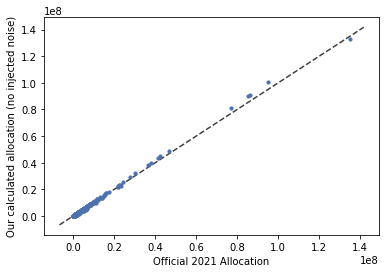

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     2.632713e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.036225e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.242385e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.242385e+08 -5.286022e+06  

[1 rows x 67 columns]

In [4]:
saipe = get_inputs(2021)
def compare_allocs(grant_type="total", **kwargs):
    allocs = funding(
        SonnenbergAuthorizer, saipe, GroundTruth(), sppe,
        allocator_kwargs=kwargs
    )
    if grant_type == "total":
        official = allocs[f"official_total_alloc"] - allocs[f"official_efig_alloc"]
    else:
        official = allocs[f"official_{grant_type}_alloc"]
    calculated = allocs[f"true_grant_{grant_type}"]
    allocs["error"] = official - calculated
    print("Average error", allocs.error.mean())
    print(
        "RMSE", 
        np.sqrt(np.mean(np.power(allocs.error, 2))), 
        "(average alloc is", 
        np.mean(allocs[f"official_total_alloc"]), 
        ")"
    )

    ax = plt.gca()
    plt.scatter(official, calculated, s=10)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    plt.xlabel("Official 2021 Allocation")
    plt.ylabel("Our calculated allocation (no injected noise)")
    plt.savefig(f"../plots/robustness/official_{grant_type}.png", dpi=300)
    plt.show()

    # plt.hist(allocs.error, bins=50)
    # plt.show()

    display(allocs[allocs.error == allocs.error.min()])

for grant_type in ["total", "basic", "concentration", "targeted"]:
    print(grant_type)
    compare_allocs(grant_type=grant_type)

## Laplace

### Results
First, using the full Sonnenberg authorization algo.

In [14]:
results = test_params(saipe, Laplace, eps=[0.01, 0.1, 1.0, 2.52, 10.0]+list(np.logspace(-3, 0.1, num=5)), trials=1000, print_results=False)
pickle.dump(results, open("../results/titlei_laplace.pkl", 'wb'))

10000 iters:


trial:   2%|▏         | 23/1000 [11:47<8:20:09, 30.72s/it]

In [ ]:
results = pickle.load(open("../results/titlei_laplace.pkl", 'rb'))

100
[0.1, 1.0, 2.52, 10.0, 30, 0.001, 0.0027825594022071257, 0.007742636826811269, 0.021544346900318832, 0.05994842503189409, 0.1668100537200059, 0.46415888336127775, 1.2915496650148828, 3.593813663804626, 10.0]
## est
## basic grants - eps=0.01 ##
# districts: 1319000
Average true alloc: 469099.6911697106
Max true alloc: 115755955.49502522
Max error: 41081041.01031256
RMSE: 350981.46743733145
RMSE in exp. error: 28184.592314618065
Avg. sum of negative misallocs: 49496872.99123061
Avg. total misalloc: 98993745.98246123
# small districts: 9744
Total avg misalloc to large districts: 67500219.75882924
Total avg misalloc to small districts: 31493526.22363177
Avg total true alloc: 6187424926.528488
## concentration grants - eps=0.01 ##
# districts: 1319000
Average true alloc: 98353.3515922628
Max true alloc: 32193815.515176307
Max error: 11238059.64840585
RMSE: 115258.14818827655
RMSE in exp. error: 32843.12500366945
Avg. sum of negative misallocs: 66155851.63691555
Avg. total misalloc: 132

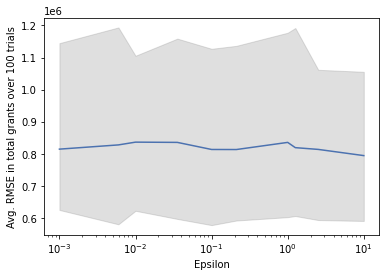

## dp
## basic grants - eps=0.01 ##
# districts: 1319000
Average true alloc: 469099.6911697106
Max true alloc: 115755955.49502522
Max error: 9407216.94240351
RMSE: 238050.52533840397
RMSE in exp. error: 179505.87006981272
Avg. sum of negative misallocs: 395101500.8969333
Avg. total misalloc: 790203001.7938689
# small districts: 9744
Total avg misalloc to large districts: 379935558.7268995
Total avg misalloc to small districts: 410267443.06696695
Avg total true alloc: 6187424926.528488
## concentration grants - eps=0.01 ##
# districts: 1319000
Average true alloc: 98353.3515922628
Max true alloc: 32193815.515176307
Max error: 4636521.143772505
RMSE: 105780.5861498917
RMSE in exp. error: 91520.21201713766
Avg. sum of negative misallocs: 194255660.56416696
Avg. total misalloc: 388511321.1283346
# small districts: 9744
Total avg misalloc to large districts: 214825842.73106772
Total avg misalloc to small districts: 173685478.39726624
Avg total true alloc: 1297280707.5019464
## targeted grant

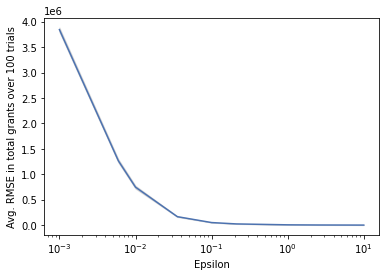

## dpest
## basic grants - eps=0.01 ##
# districts: 1319000
Average true alloc: 469099.6911697106
Max true alloc: 115755955.49502522
Max error: 46176883.66141674
RMSE: 401594.3227477253
RMSE in exp. error: 175768.93190241608
Avg. sum of negative misallocs: 383685710.26180035
Avg. total misalloc: 767371420.5236051
# small districts: 9744
Total avg misalloc to large districts: 366627789.8423903
Total avg misalloc to small districts: 400743630.6812103
Avg total true alloc: 6187424926.528488
## concentration grants - eps=0.01 ##
# districts: 1319000
Average true alloc: 98353.3515922628
Max true alloc: 32193815.515176307
Max error: 14051631.817785423
RMSE: 142875.71568961174
RMSE in exp. error: 95989.45940475028
Avg. sum of negative misallocs: 212264012.01089662
Avg. total misalloc: 424528024.0217924
# small districts: 9744
Total avg misalloc to large districts: 248152307.54114485
Total avg misalloc to small districts: 176375716.48064843
Avg total true alloc: 1297280707.5019464
## targeted 

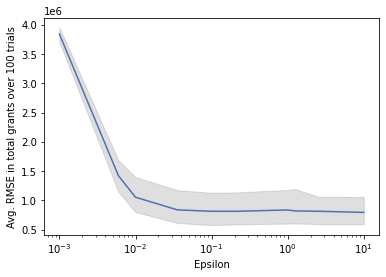

Name  \
trial delta epsilon  State FIPS Code District ID                                        
0     0.0   0.010000 1               190               Alabaster City School District   
                                     5               Albertville City School District   
                                     30           Alexander City City School District   
                                     60                Andalusia City School District   
                                     90                 Anniston City School District   
...                                                                               ...   
99    0.0   1.258925 56              4260              Uinta County School District 6   
                                     6240           Washakie County School District 1   
                                     5820           Washakie County School District 2   
                                     4830             Weston County School District 1   
                                     6090             Weston County School District 7   

                                                  official_basic_hold_harmless  \
trial delta epsilon  State FIPS Code District ID                                 
0     0.0   0.010000 1               190                         451569.585546   
                                     5                           820486.906460   
                                     30                          548830.474149   
                                     60                          255888.455695   
                                     90                          690724.128654   
...                                                                        ...   
99    0.0   1.258925 56              4260                         40822.247350   
                                     6240                        223321.706091   
                                     5820                             0.000000   
                                     4830                        182499.458741   
                                     6090                         20411.123675   

                                                  official_concentration_hold_harmless  \
trial delta epsilon  State FIPS Code District ID                                         
0     0.0   0.010000 1               190                                  58092.627841   
                                     5                                   200836.024036   
                                     30                                  135670.119992   
                                     60                                   63255.265741   
                                     90                                  170746.031480   
...                                                                                ...   
99    0.0   1.258925 56              4260                                     0.000000   
                                     6240                                 24485.720477   
                                     5820                                  5762.953584   
                                     4830                                 93609.867864   
                                     6090                                     0.000000   

                                                  official_targeted_hold_harmless  \
trial delta epsilon  State FIPS Code District ID                                    
0     0.0   0.010000 1               190                            182516.637263   
                                     5                              553590.326339   
                                     30                             392958.114409   
                                     60                             157617.381627   
                                     90                             537272.595916   
...                                                                           ...   
99   

In [13]:
print(len(results.groupby("trial")))
print([0.1, 1.0, 2.52, 10.0, 30]+list(np.logspace(-3, 1, num=10)))
test_params(None, None, results=results, print_results=[0.01, 0.1, 1.0, 10.0, 30.0], plot_results=True)

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [8]:
grants = funding(AbowdAllocator, saipe, Laplace(2.52, 0, sensitivity=2.0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

Mean Sq. SPPE (2018): 25804346.403312244


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [9]:
# RMSE
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

5687.452208208677

In [10]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 52144217.36587607


In [11]:
grants = funding(AbowdAllocator, saipe, Laplace(4.74, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

3022.9215913293833

In [12]:
grants = funding(AbowdAllocator, saipe, Laplace(0.1, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

2390438.406534202

## Uncertainty

Adapted from `plot_sampling.ipynb`.

In [3]:
eps = [0.001, 0.01, 0.1, 1.0, 10]
num_trials = 100
num_bins = 10

In [4]:
laplace = test_params(saipe, Laplace, eps=[0.001, 0.01, 0.1, 1.0, 10], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
# gaussian = test_params(saipe, Gaussian, eps=[0.01, 0.1, 2.52], delta=[1e-6], trials=num_trials, print_results=False, plot_results=False)

pickle.dump(laplace, open("../results/bootstrap/laplace.pkl", 'wb'))
# pickle.dump(gaussian, open("../results/bootstrap/gaussian.pkl", 'wb'))

In [4]:
baseline = test_params(saipe, GroundTruth, eps=[0.0], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
pickle.dump(baseline, open("../results/bootstrap/baseline.pkl", 'wb'))

100 iters:


trial: 100%|██████████| 100/100 [07:06<00:00,  4.27s/it]


In [5]:
baseline = pickle.load(open("../results/bootstrap/baseline.pkl", 'rb'))
laplace = pickle.load(open("../results/bootstrap/laplace.pkl", 'rb'))
# gaussian = pickle.load(open("../results/bootstrap/gaussian.pkl", 'rb'))

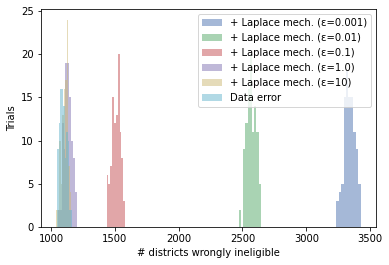

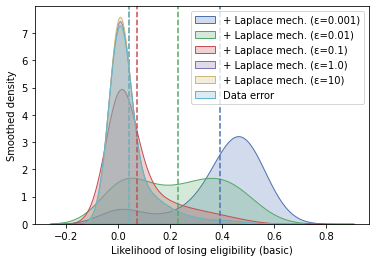

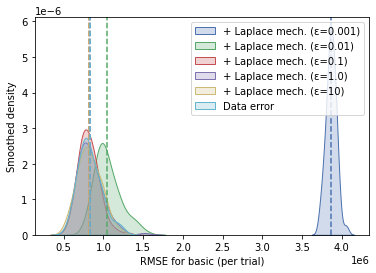

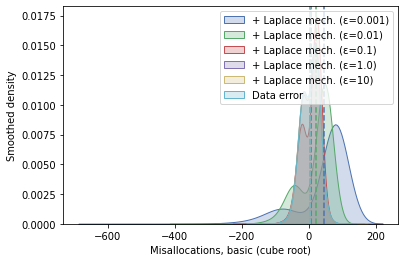

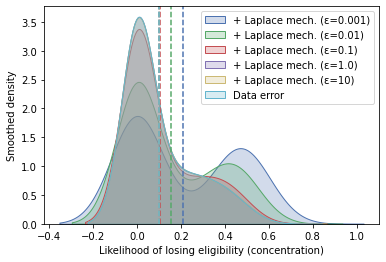

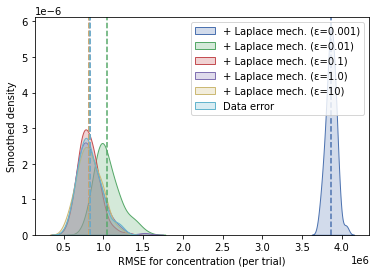

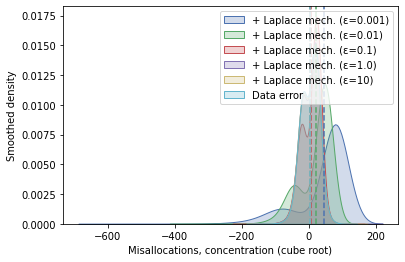

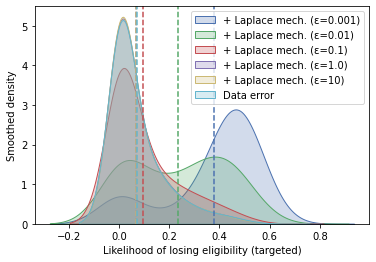

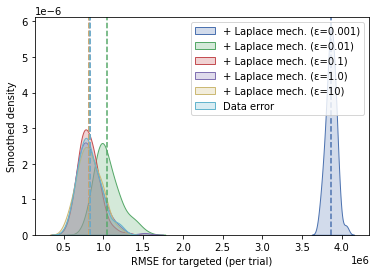

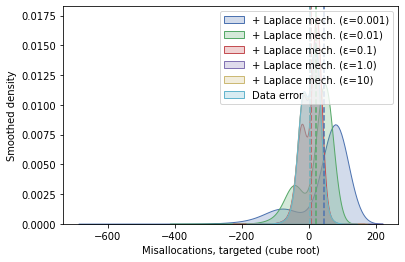

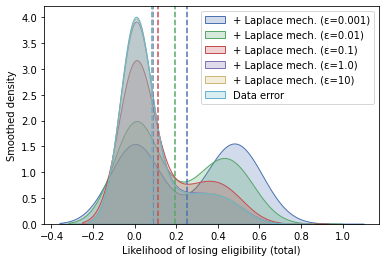

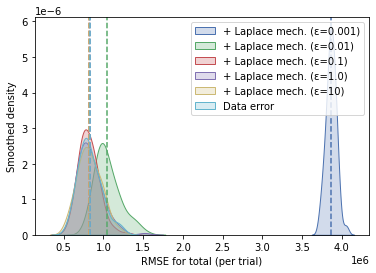

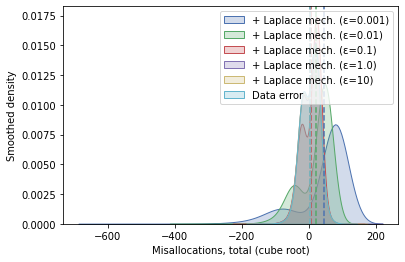

In [6]:
treatments = {
  "+ Laplace mech. (ε={})".format(e): laplace.loc[pd.IndexSlice[:, 0.0, e, :, :], :].copy()
  for e in eps
}
treatments["Data error"] = baseline

plot_treatments(
  treatments,
  lambda df: df.groupby('trial')["lost_eligibility"].sum(),
  plt.hist,
  dict(bins=num_bins, alpha=0.5),
  filename="ineligible_hist",
  xlab="# districts wrongly ineligible",
  ylab="Trials"
)

for grant in [
  "basic",
  "concentration",
  "targeted",
  "total"
]:
  plot_treatments(
    treatments,
    lambda df: df.groupby(['State FIPS Code', 'District ID'])["lost_eligibility"].mean(),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"likelihood_ineligible_{grant}",
    xlab=f"Likelihood of losing eligibility ({grant})",
    grant=grant,
    mean_line=True
  )

  plot_treatments(
    treatments,
    lambda df: np.sqrt(df.groupby('trial')["misalloc_sq"].mean()),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"rmse_{grant}",
    xlab=f"RMSE for {grant} (per trial)",
    mean_line=True
  )

  plot_treatments(
    treatments,
    lambda df: \
      np.sign(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean())*np.power(
        np.abs(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean()), 1/3),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"misalloc_{grant}",
    xlab=f"Misallocations, {grant} (cube root)",
    mean_line=True
  )

## Discrimination

In [3]:
eps = 0.1

results = load_treatments("baseline")['baseline'].loc[pd.IndexSlice[:, 0.0, eps, :, :], :]
print(results.shape)

(13190000, 38)


In [3]:
grants = discrimination_join(results, save_path=f"../results/baseline_eps={eps}", verbose=True)

[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
(13294, 257)
(13293, 341)
(13294, 203)
(13294, 495)
['Total population (RACE) - est', 'White (RACE) - pct', 'Black or African American (RACE) - pct', 'Cherokee tribal grouping (RACE) - pct', 'Chippewa tribal grouping (RACE) - pct', 'Navajo tribal grouping (RACE) - pct', 'Sioux tribal grouping (RACE) - pct', 'Asian (RACE) - pct', 'Asian Indian (RACE) - pct', 'Chinese (RACE) - pct', 'Filipino (RACE) - pct', 'Japanese (RACE) - pct', 'Korean (RACE) - pct', 'Vietnamese (RACE) - pct', 'Other Asian (RACE) - pct', 'Native Hawaiian (RACE) - pct', 'Guamanian or Chamorro (RACE) - pct', 'Samoan (RACE) - pct', 'Some other race (RACE) - pct', 'Two or more races (RACE) - pct', 'Mexican (HISPANIC OR LATINO AND RACE) - pct', 'Puerto Rican (HISPANIC OR LATINO AND RACE) - pct', 'Cuban (HISPANIC OR LATINO AND RACE) - pct', 'Othe

In [5]:
grants = pd.read_feather(f"../results/baseline_eps={eps}.feather")
# simple stats
income = pd.to_numeric(grants['Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est'], errors='coerce')
print(
  "districts between 25,000 and 75,000 in income:", 
  np.sum((income > 25000) & (income < 75000)) / len(income)
)

density = np.log(grants["true_pop_total"] / grants["ALAND"])
print(
  "districts with high density",
  np.sum(density > -10) / len(density)
)

districts between 25,000 and 75,000 in income: 0.557301153612629
districts with high density 0.409608378870674


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Geography

13190000


/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(


<AxesSubplot:>

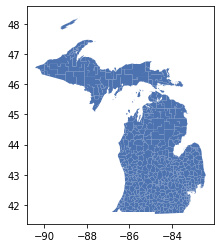

In [4]:
print(len(results))
joined = geo_join(results)
joined.loc[26].plot()

All but 3967 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 7.861327860665354


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


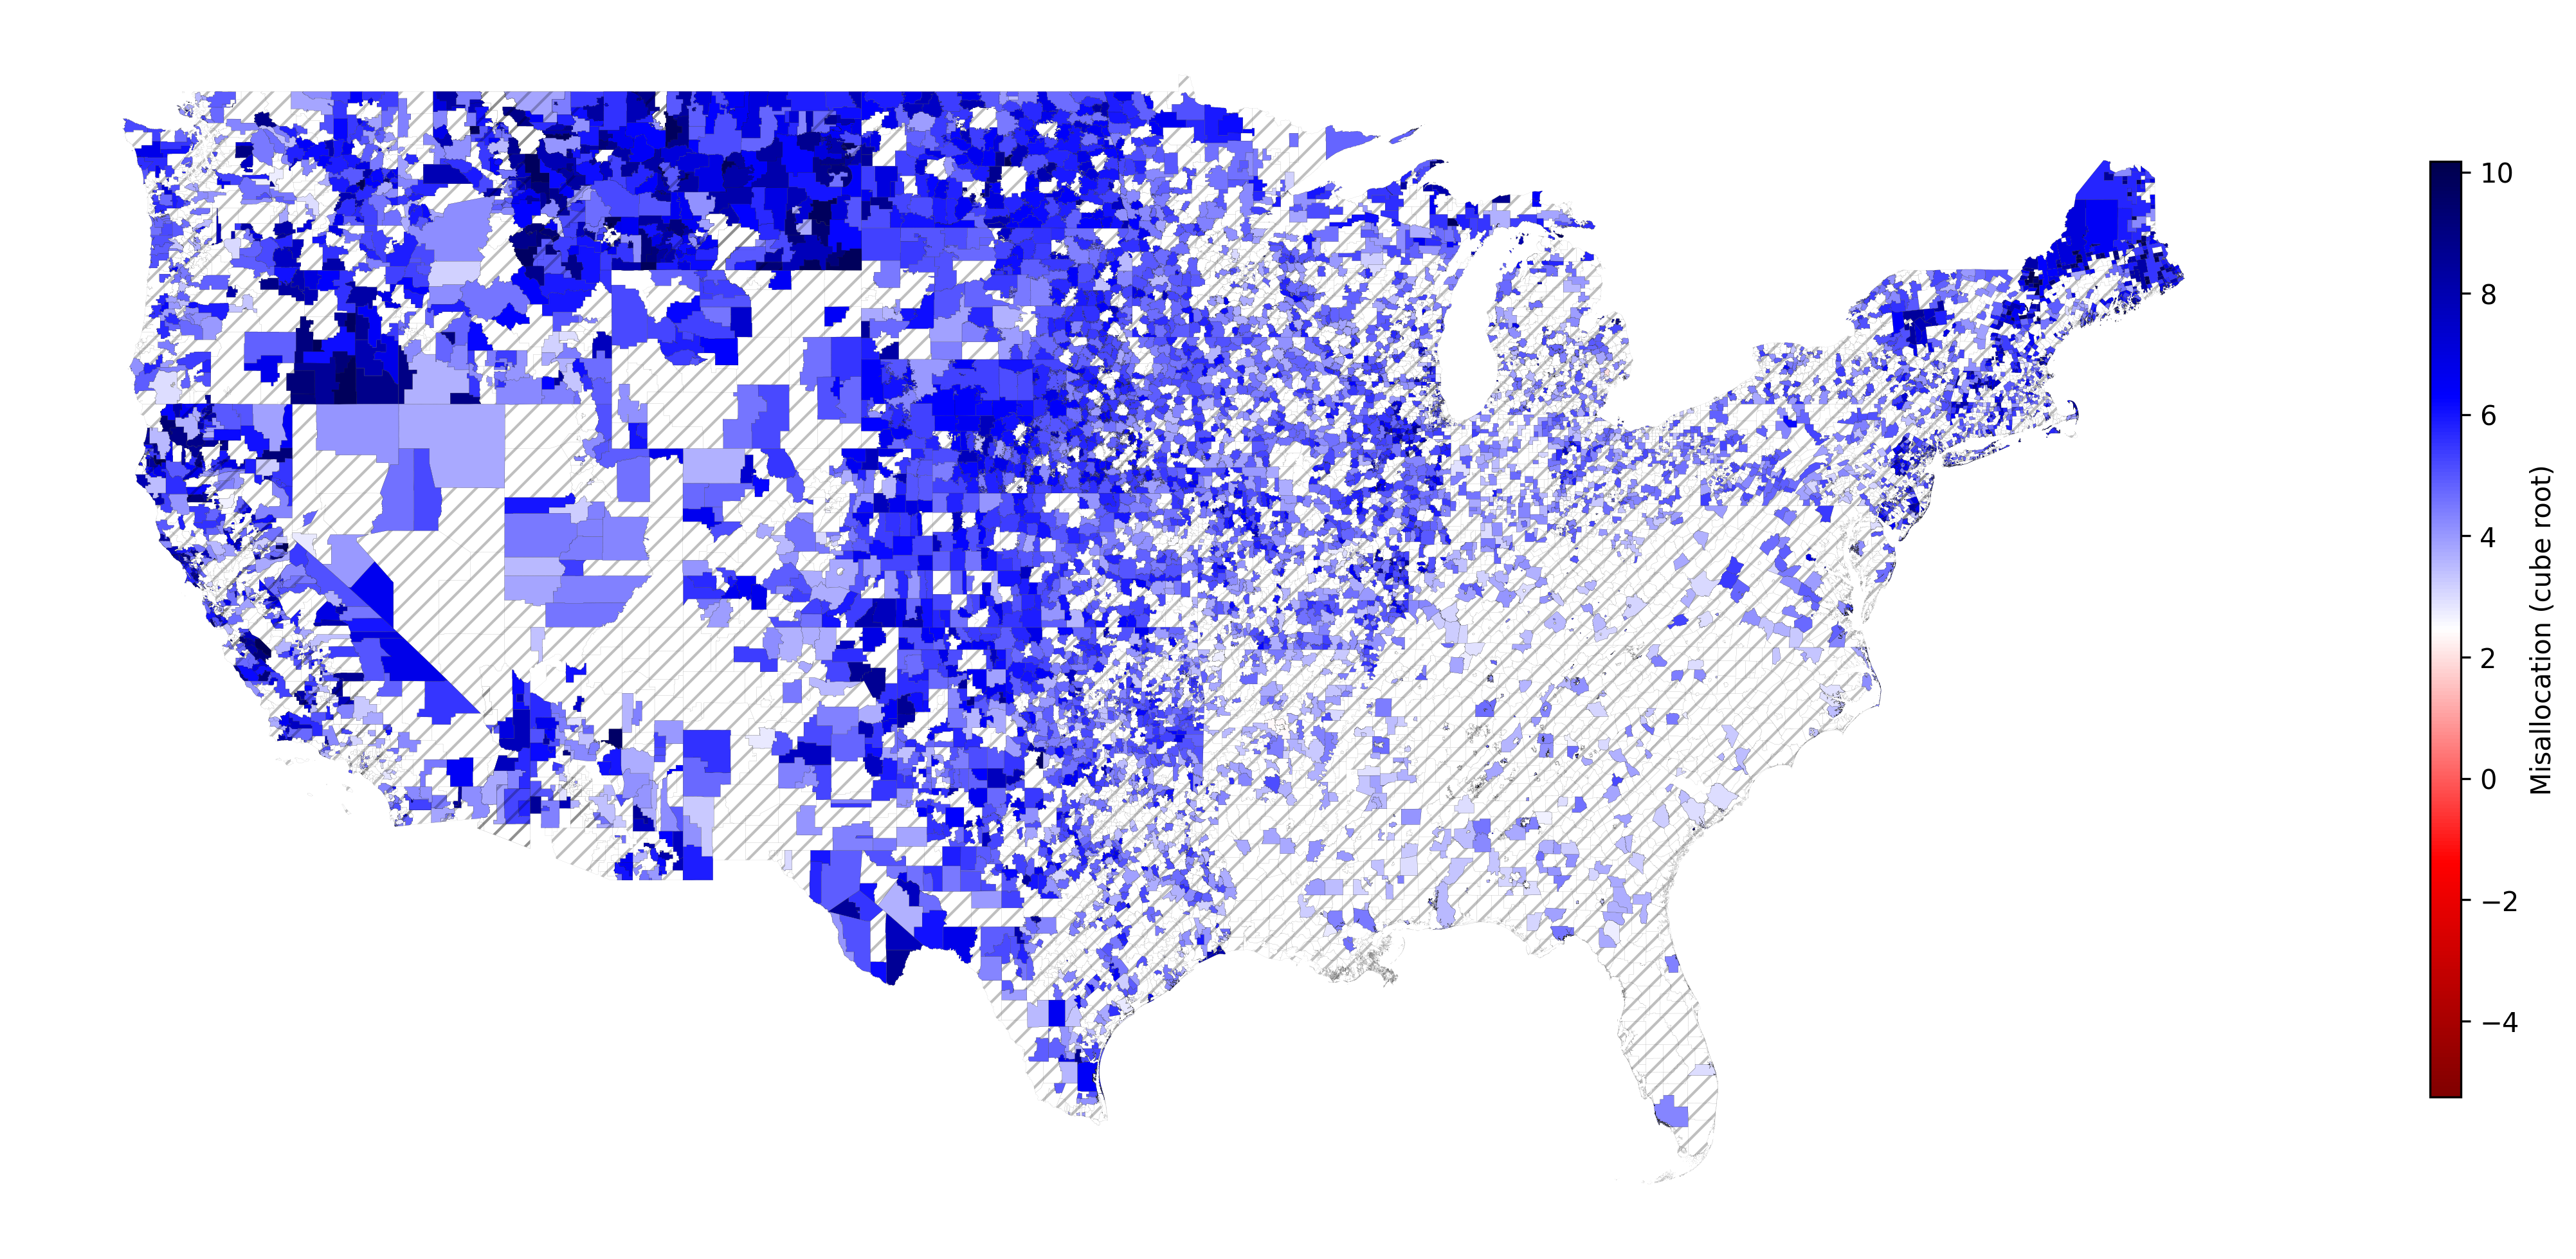

Exception: 

In [8]:
dperr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_dp_per_child_eligible"])
dpmin = dperr.min()
dpmax = dperr.max()
serr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_per_child_eligible"])
smin = serr.min()
smax = serr.max()
ymin = smin if smin <= dpmin else dpmin
ymax = smax if smax >= dpmax else dpmax


# heatmap(
#     joined.loc[[
#         f for f in joined.index.get_level_values("State FIPS Code").unique()
#         if f not in [2, 15]
#     ]],
#     label="Misallocation (cube root)",
#     y="error_dp_per_child_eligible",
#     # file="misalloc_nation.png",
#     figsize=(15,10),
#     bar_location = 'right',
#     transform='log'
#     # min=ymin,
#     # max=ymax
# )

# raise Exception

heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    label="Misallocation per eligible child (cube root)",
    y="error_dp_per_child_eligible",
    file="misalloc_nation.png",
    figsize=(15,10),
    bar_location = 'right'
    # min=ymin,
    # max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="error_per_child_eligible",
    label="Misallocation per eligible child (cube root)",
    file="misalloc_nation_sampling.png",
    figsize=(15,10),
    bar_location = 'right',
    min=ymin,
    max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="dp_marginal",
    label="Misallocation per eligible child (cube root)",
    file="misalloc_nation_marginal.png",
    figsize=(15,10),
    bar_location = 'right'
)

All but 3 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.0


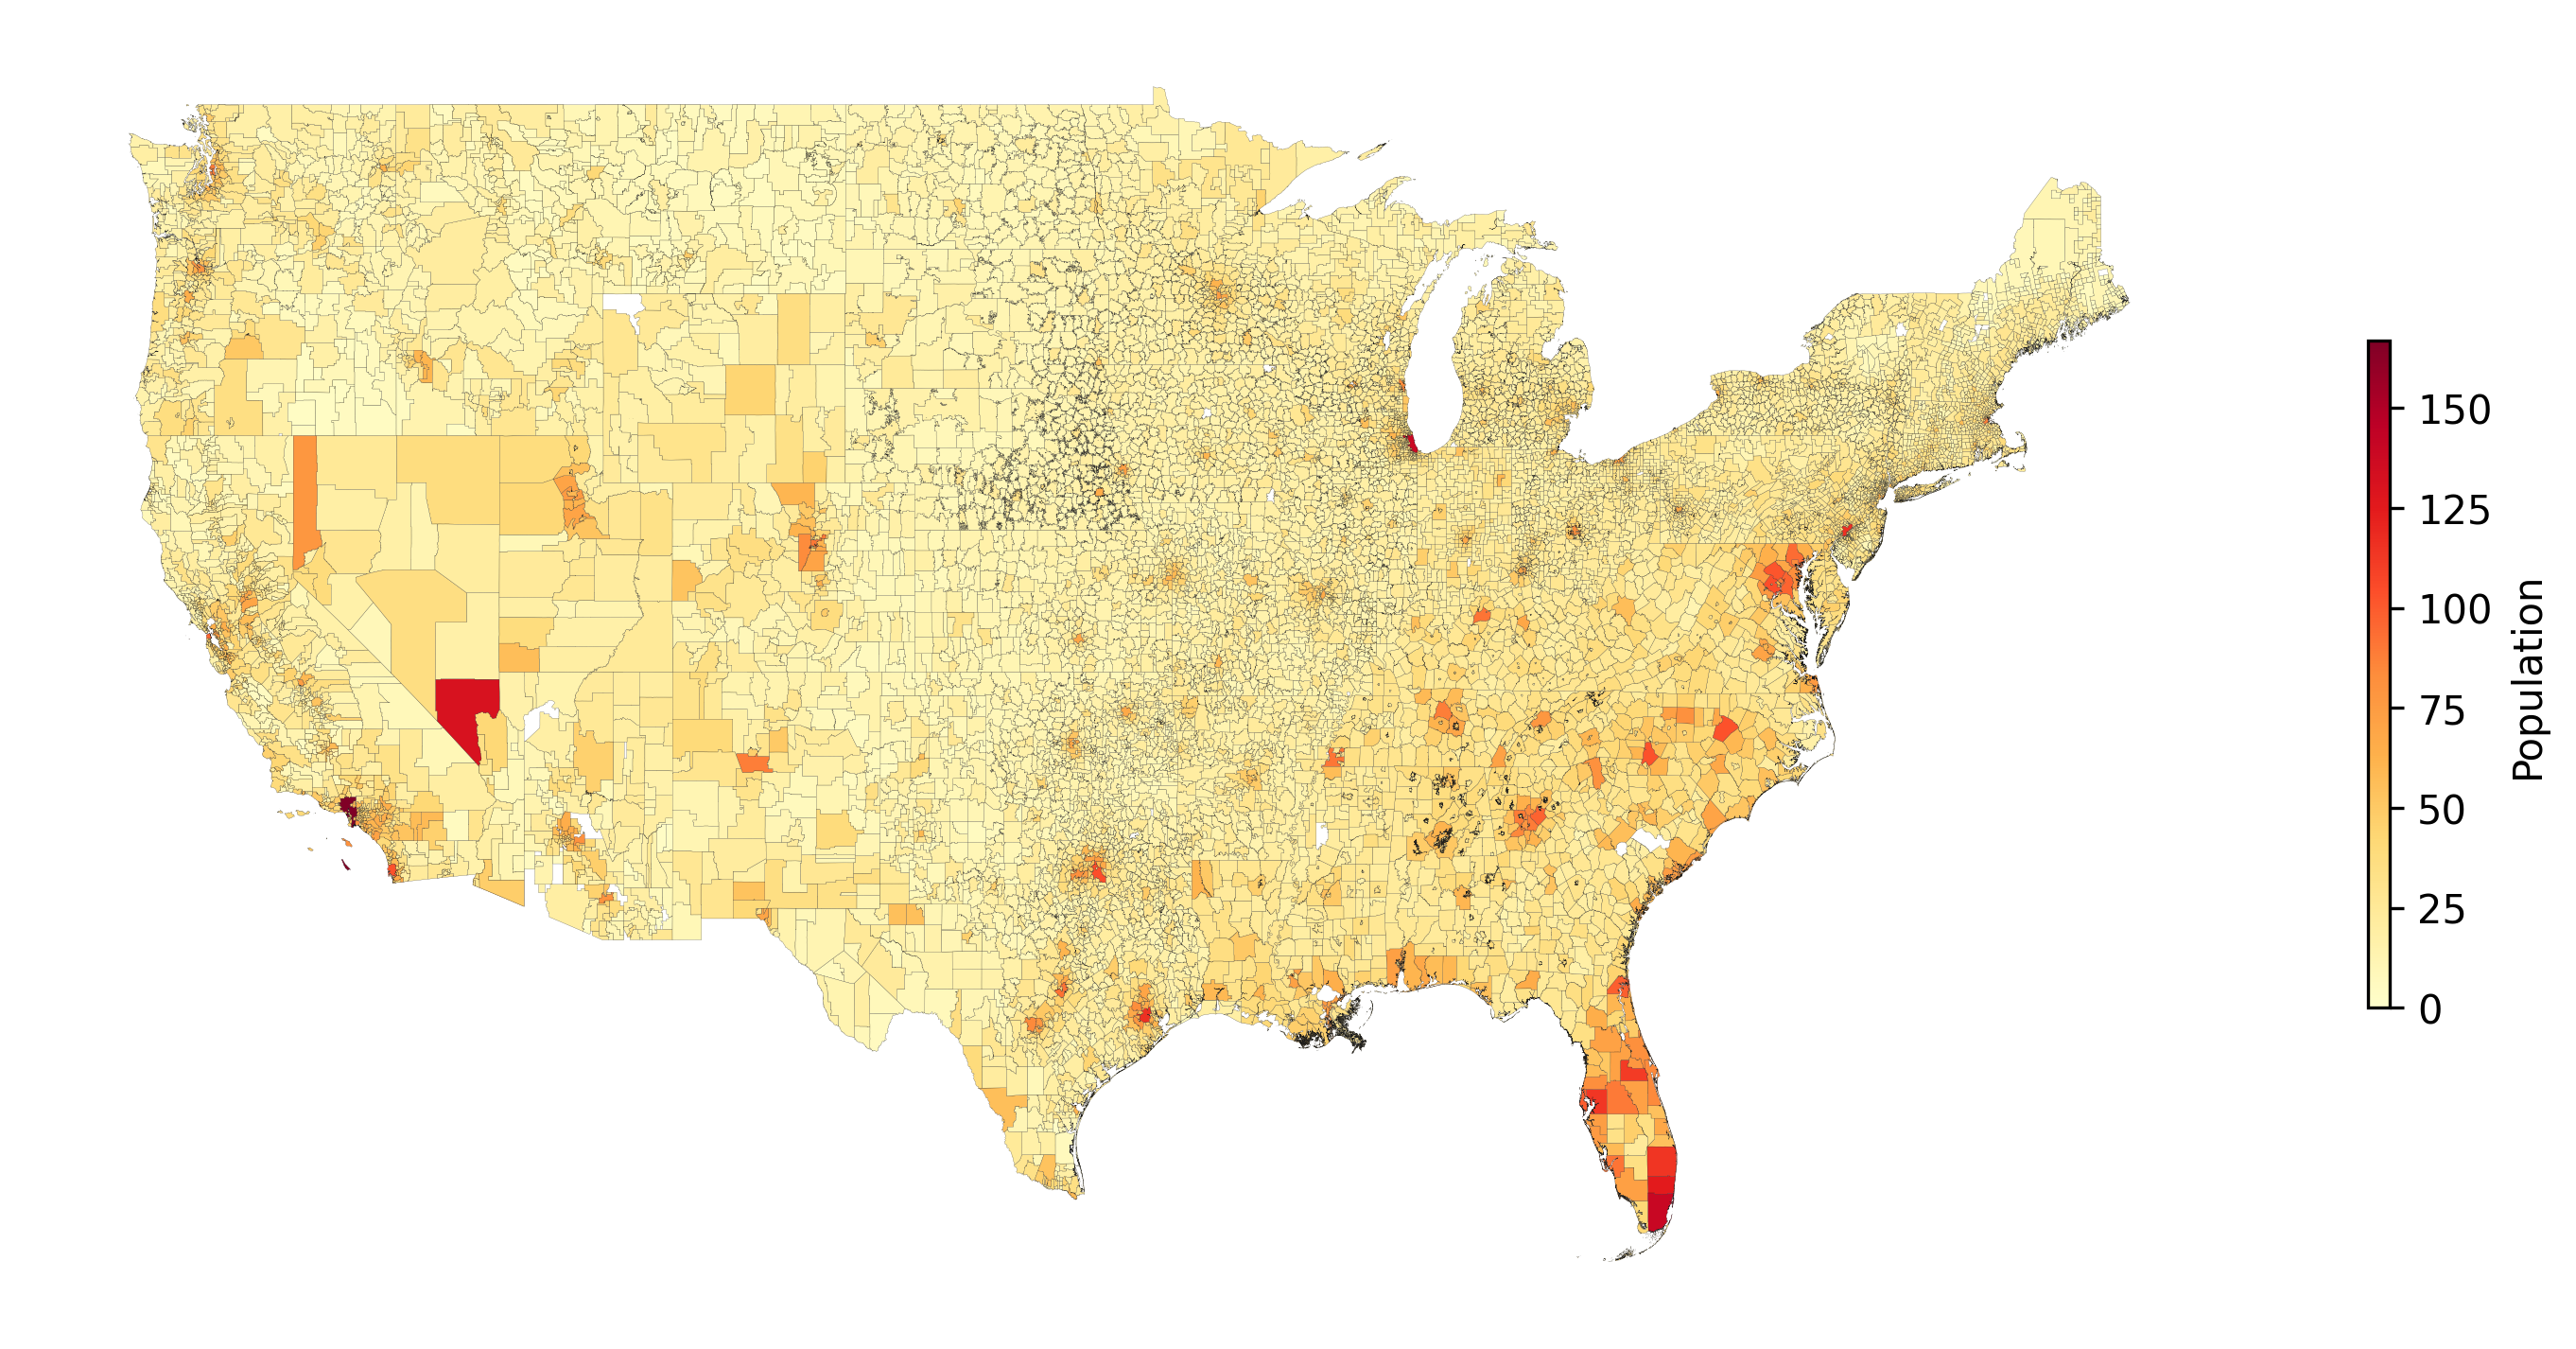

In [6]:
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    "Population",
    vcenter=None,
    y="true_pop_total",
    theme="YlOrRd"
)

In [6]:
acs = get_acs_unified()
joined_acs = joined.join(acs['White (RACE) - pct'], how="left")
joined_acs["prop_nonwhite"] = 1 - pd.to_numeric(joined_acs['White (RACE) - pct'], errors='coerce') / 100
joined_acs.prop_nonwhite.describe()
for state in [
#     (26, "Michigan"),
#     (37, "North Carolina"),
    # (72, "Puerto Rico"),
    (42, "Pennsylvania")
]:
    # heatmap(joined_acs.loc[state[0]], "Prop. non-white-only", y="prop_nonwhite", transform=None, vcenter=None, theme="Blues")
    # heatmap(joined.loc[state[0]], "% switched eligibility for any grant", y="switched_eligibility", transform=None, vcenter=None, theme="Oranges")
    heatmap(
        joined.loc[state[0]], 
        "Likelihood of becoming wrongly ineligible for any grant", 
        file="ineligible.png",
        y="became_ineligible", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0
    )
    heatmap(
        joined.loc[state[0]], 
        "Likelihood of becoming wrongly ineligible for any grant", 
        file="ineligible_dp.png",
        y="became_ineligible_dp", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0
    )
    heatmap(
        joined.loc[state[0]], 
        "Likelihood of becoming wrongly eligible for any grant", 
        file="eligible.png",
        y="became_eligible", transform=None, vcenter=None, theme="Greens",
        min=0
    )
    heatmap(
        joined.loc[state[0]], 
        "Likelihood of becoming wrongly eligible for any grant", 
        file="eligible_dp.png",
        y="became_eligible_dp", transform=None, vcenter=None, theme="Greens",
        min=0
    )
    # heatmap(joined.loc[state[0]], f"Misallocation per child in {state[1]} (cube root)")
    # heatmap(joined.loc[state[0]], f"Misallocation per eligible child in {state[1]} (cube root)", y="error_per_child_eligible")
    # heatmap(joined.loc[state[0]], "Log eligible children", y="true_children_eligible", transform='log', vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "% eligible children", y="percent_eligible", transform=None, vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "Log population", y="true_pop_total", transform='log', vcenter=None, theme="Greens")
    # heatmap(joined.loc[state[0]], "Log status quo entitlement", y="true_grant_total", transform='log', vcenter=None, theme="Greens")

[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 32 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.02601996449238452


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 27 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.026019600197216913


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 283 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.026017882737008387


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 271 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.02601996449238454


## Experimental treatments

In [3]:
experiment_kwargs = dict(
  trials = 1000,
  eps = [0.1],
  delta = [0.0],
  baseline = load_treatments("baseline")['baseline']
)

In [4]:
experiment_kwargs['baseline']['true_children_eligible'].describe()

count    1.319000e+07
mean     6.459567e+02
std      2.982825e+03
min      0.000000e+00
25%      5.500000e+01
50%      1.530000e+02
75%      4.290000e+02
max      1.529460e+05
Name: true_children_eligible, dtype: float64

### Hold harmless provision

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# No hold harmless (baseline)
True budget: 11661575735226.518
DP est budget: 11661575735226.521
Avg prop. districts erroneously ineligible: 2430.836
RMSE: 834865.1466815167
Avg. (per trial) # of districts losing $$: 6328.799
Total avg. (per sd) losses: 135079716.31794167
Total 5% quantile losses: 4368238003.859437
Total avg. losses (data error): 106857613.88472036
Avg. marginal losses (DP): 40957164.87093997
13190000

# Hold harmless
True budget: 11661575735226.518
DP est budget: 11661575735226.53
Avg prop. districts erroneously ineligible: 2434.964
RMSE: 635789.11704973
Avg. (per trial) # of districts losing $$: 5190.301
Total avg. (per sd) losses: 484674613.7719047
Total 5% quantile losses: 1797573701.1049519
To

/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


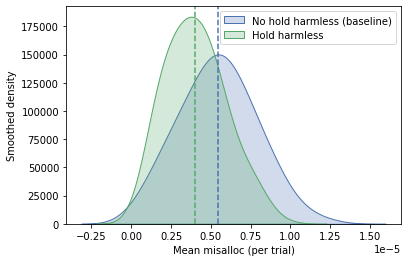

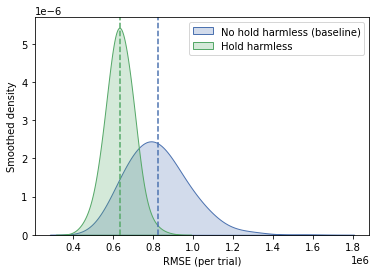

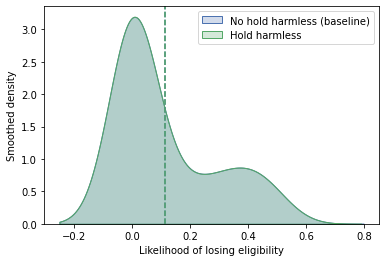

Plotting error_per_child


/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 1197 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.314558088758214


In [11]:
experiment = Experiment.get_experiment("hold_harmless", **experiment_kwargs)
experiment.plot()

### Post-processing

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# None
True budget: 11661575735226.518
DP est budget: 11661575735226.523
Avg prop. districts erroneously ineligible: 2433.081
RMSE: 827794.0038242367
Avg. (per trial) # of districts losing $$: 6329.134
Total avg. (per sd) losses: 135618394.71213165
Total 5% quantile losses: 4365965529.451725
Total avg. losses (data error): 107961143.18492503
Avg. marginal losses (DP): 40891616.38650902
13190000

# Clipping (baseline)
True budget: 11661575735226.518
DP est budget: 11661575735226.521
Avg prop. districts erroneously ineligible: 2430.836
RMSE: 834865.1466815167
Avg. (per trial) # of districts losing $$: 6328.799
Total avg. (per sd) losses: 135079716.31794167
Total 5% quantile losses: 4368238003.859437
Total avg. losse

/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


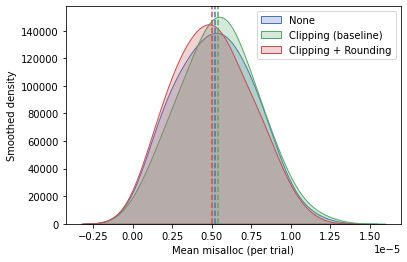

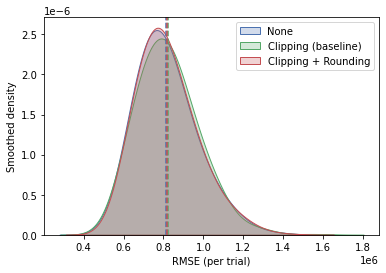

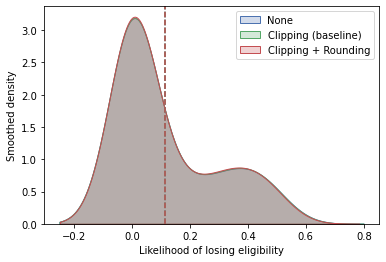

Plotting error_per_child


/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


All but 4846 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.479180619361243
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 4892 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.441330417731699


In [12]:
experiment = Experiment.get_experiment("post_processing", **experiment_kwargs)
experiment.plot()

### Moving average

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# Lag 0
True budget: 11661575735226.54
DP est budget: 11661575735226.521
Avg prop. districts erroneously ineligible: 2398.474
RMSE: 835421.3549002113
Avg. (per trial) # of districts losing $$: 6323.088
Total avg. (per sd) losses: 142138542.02668336
Total 5% quantile losses: 4368238003.859437
Total avg. losses (data error): 113583042.44385895
Avg. marginal losses (DP): 40957164.87093997
13190000

# Lag 1
True budget: 11661575735226.54
DP est budget: 11661575735226.547
Avg prop. districts erroneously ineligible: 1350.613
RMSE: 59433.0014168922
Avg. (per trial) # of districts losing $$: 6574.334
Total avg. (per sd) losses: 59144460.666210674
Total 5% quantile losses: 837428695.7778311
Total avg. losses (data error): 

/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


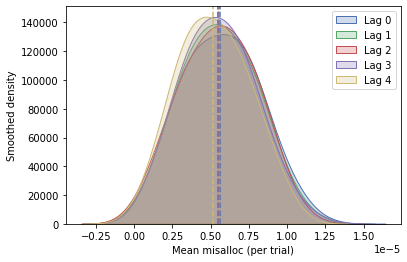

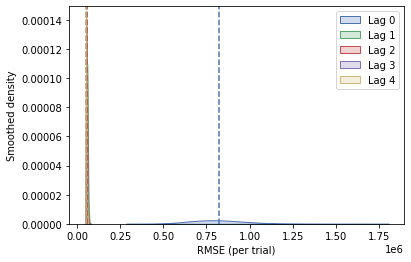

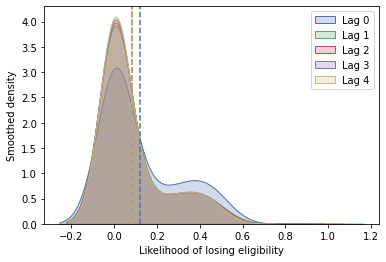

Plotting error_per_child


/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packag

All but 4628 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 2939 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.5417134859222488
All but 2590 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.2729425360086024
All but 4653 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.5510822675496874
All but 7704 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.0846028954150975


In [13]:
experiment = Experiment.get_experiment("moving_average", **experiment_kwargs)
experiment.plot()

### Alternative thresholding

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# None
True budget: 11661575735226.518
DP est budget: 11661575735226.52
Avg prop. districts erroneously ineligible: 0.0
RMSE: 833298.1576021631
Avg. (per trial) # of districts losing $$: 5542.377
Total avg. (per sd) losses: 391411275.40978837
Total 5% quantile losses: 4063256081.140558
Total avg. losses (data error): 367005483.36323524
Avg. marginal losses (DP): 33103874.87486943
13190000

# Hard (baseline)
True budget: 11661575735226.518
DP est budget: 11661575735226.521
Avg prop. districts erroneously ineligible: 2430.836
RMSE: 834865.1466815167
Avg. (per trial) # of districts losing $$: 6328.799
Total avg. (per sd) losses: 135079716.31794167
Total 5% quantile losses: 4368238003.859437
Total avg. losses (data er

/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.p

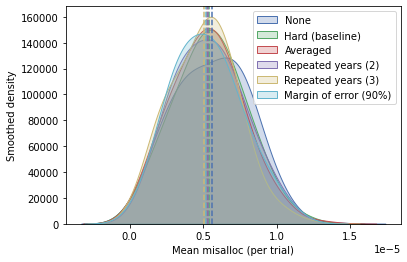

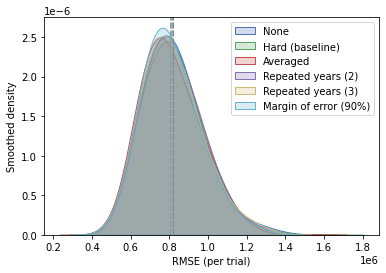

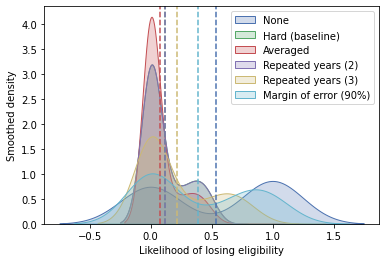

Plotting error_per_child


/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packag

All but 1932 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.230177290055269
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 8079 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.316067540415581
All but 4920 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.490327698595198
All but 5077 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.469121834489666
All but 3201 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.3081303243192535


In [14]:
experiment = Experiment.get_experiment("thresholds", **experiment_kwargs)
experiment.plot()

### Epsilon Sensitivity

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
[WARN] Epsilon is none - only use this if there is only one eps value in the df.
13190000

# 0.001
True budget: 11661575735226.518
DP est budget: 11661575735226.543
Avg prop. districts erroneously ineligible: 5721.446
RMSE: 3856546.6383254398
Avg. (per trial) # of districts losing $$: 7499.224
Total avg. (per sd) losses: 5551353202.579651
Total 5% quantile losses: 10662712121.062153
Total avg. losses (data error): 105344700.12856969
Avg. marginal losses (DP): 5516173163.238873
13190000

# 0.01
True budget: 11661575735226.518
DP est budget: 11661575735226.545
Avg prop. districts erroneously ineligible: 4216.44
RMSE: 1057198.6105746557
Avg. (per trial) # of districts losing $$: 6936.826
Total avg. (per sd) losses: 1089460610.04641
Total 5% quantil

/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.p

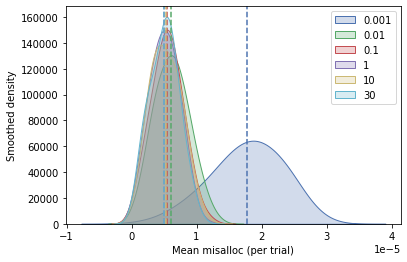

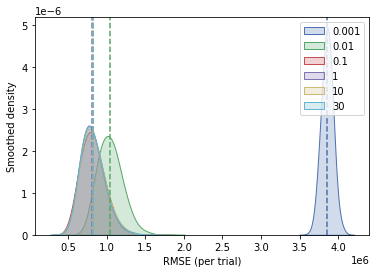

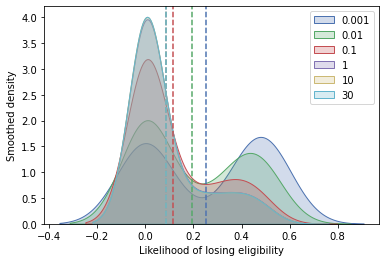

Plotting error_per_child


/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packag

All but 4888 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.504062637901318
All but 4882 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.470929850024668
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 4889 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.477590831920147
All but 4915 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.487953583339739
All but 4924 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.483007391042044


In [15]:
experiment = Experiment.get_experiment("epsilon", **experiment_kwargs)
experiment.plot()

### Budget increases

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# Biden proposal ($2.0e+10)
True budget: 11661575735226.518
DP est budget: 26392660487364.074
Avg prop. districts erroneously ineligible: 2431.081
RMSE: 6959012.192105953
Avg. (per trial) # of districts losing $$: 1704.618
Total avg. (per sd) losses: 0.0
Total 5% quantile losses: 546559293.2746782
Total avg. losses (data error): 0.0
Avg. marginal losses (DP): 92184152.26183051
13190000

# + loss ($1.4e+08)
True budget: 11661575735226.518
DP est budget: 11761069272692.113
Avg prop. districts erroneously ineligible: 2433.142
RMSE: 839507.227883841
Avg. (per trial) # of districts losing $$: 6214.466
Total avg. (per sd) losses: 71355889.22629642
Total 5% quantile losses: 4308834336.831855
Total avg. losses (data error

/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


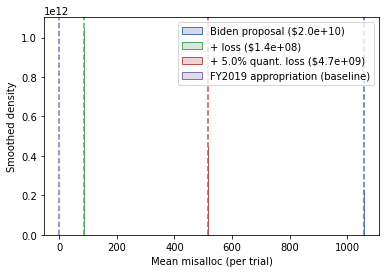

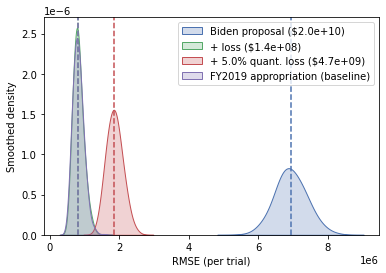

In [4]:
experiment = Experiment.get_experiment("budget", **experiment_kwargs)
experiment.plot()

### Sampling variance sensitivity

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# Gaussian (0.5)
True budget: 11661575735226.518
DP est budget: 11661575735226.527
Avg prop. districts erroneously ineligible: 1754.718
RMSE: 419764.8259025484
Avg. (per trial) # of districts losing $$: 6335.51
Total avg. (per sd) losses: 83107204.71600416
Avg. expected loss: -15766.876250427655
Total 5% quantile losses: 2439313969.444535
Avg. 5% quantile loss: -195661.66434944532
Total avg. losses (data error): 53090634.07408292
Avg. marginal losses (DP): 42132266.68516384
13190000

# Gaussian (0.75)
True budget: 11661575735226.518
DP est budget: 11661575735226.533
Avg prop. districts erroneously ineligible: 2089.537
RMSE: 631364.754454398
Avg. (per trial) # of districts losing $$: 6333.162
Total avg. (per sd) lo

/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/series.p

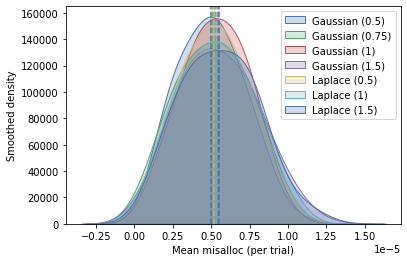

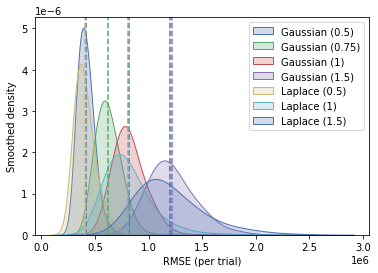

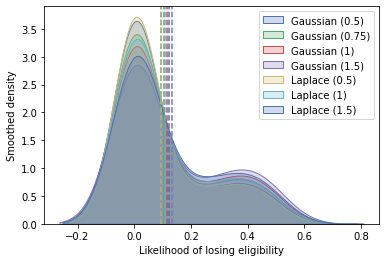

Plotting error_per_child


/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/rsteed/dp-acs/venv/lib64/python3.6/site-packag

All but 6499 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.026153442114566
All but 5493 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.2137342977930725
All but 4936 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.485819679186682
All but 3871 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.852386883230494
All but 6653 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.013733619409673
All but 5103 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.501875553823508
All but 4073 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.941599828707744


In [5]:
experiment = Experiment.get_experiment("sampling", **experiment_kwargs)
experiment.plot()

## [DEPRECATED] Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: overflow encountered in exp
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: invalid value encountered in double_scalars
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: overflow encountered in exp
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta


(0.001, 0.027825594022071243, 0.774263682681127, 2.52, 21.54434690031882, 599.4842503189409, 16681.005372000593, 464158.8833612772, 12915496.650148828, 359381366.3804626, 10000000000.0)
## dp
## basic grants ##
RMSE at eps=2.52: 21399.19796113853
RMSE prop eps=2.52: 0.004691125745169814
Total misalloc at eps=2.52: 1857499037.3476112
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 100671.3283797714
RMSE prop eps=2.52: 0.006430091290918551
Total misalloc at eps=2.52: 1869504093.5586305
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 56692.94880990919
RMSE prop eps=2.52: 0.004404833980625078
Total misalloc at eps=2.52: 2903765215.9326797
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 15266.238953544133
RMSE prop eps=2.52: 0.00492429570329448
Total misalloc at eps=2.52: 787839065.3432262
Total true alloc: 159990202216.03195


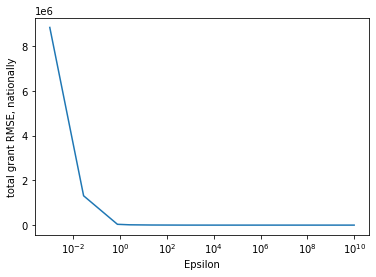

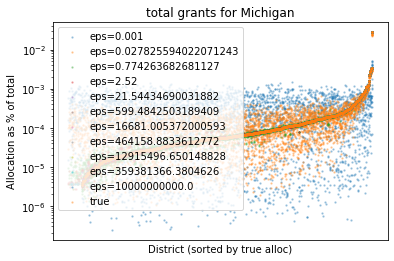

/Users/steed/dp-acs/dp_policy/api.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (


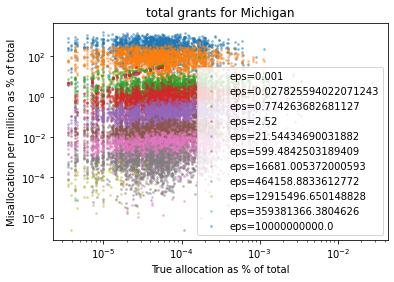

## dpest
## basic grants ##
RMSE at eps=2.52: 2730892.7708471036
RMSE prop eps=2.52: 0.1605220789051688
Total misalloc at eps=2.52: 64100091418.47471
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 3115379.4280794035
RMSE prop eps=2.52: 0.2559038715010952
Total misalloc at eps=2.52: 75780426908.8416
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 7905797.344754197
RMSE prop eps=2.52: 0.20086854941523397
Total misalloc at eps=2.52: 136090233079.47676
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 1550976.8201538778
RMSE prop eps=2.52: 0.20096552176913365
Total misalloc at eps=2.52: 32152514466.29373
Total true alloc: 159990202216.03195


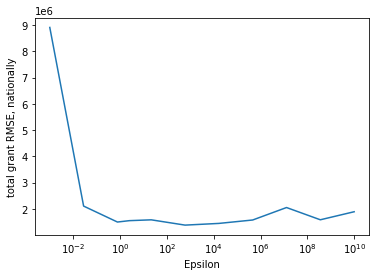

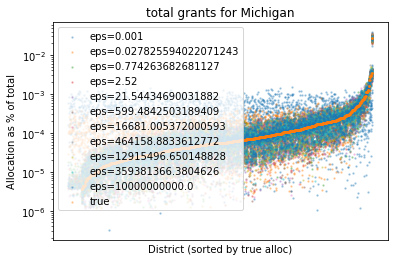

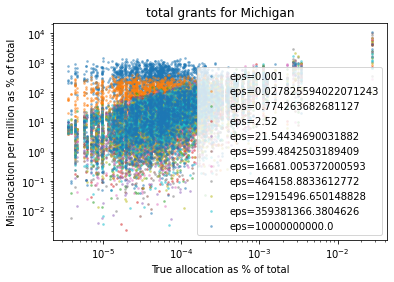

In [18]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(1e-8, 1e-5, endpoint=False, num=10)),
    auth=False
)

Comparing dp


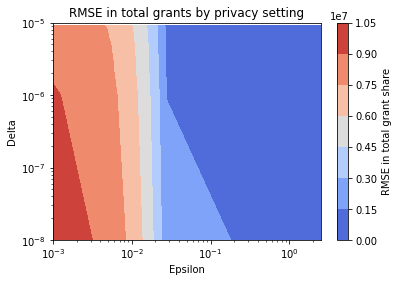

Comparing dpest


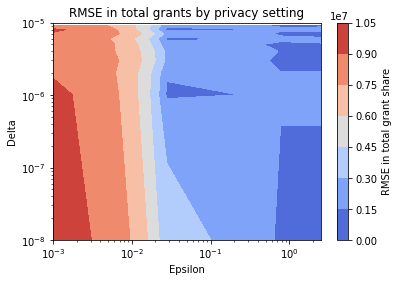

In [25]:
for prefix in ('dp', 'dpest'):
    print("Comparing", prefix)

    grant_type = 'total'

    eps = list(results.index.get_level_values("epsilon").unique())

    delts = list(results.index.get_level_values("delta").unique())
    mse = np.zeros((len(eps), len(delts)))
    for params, alloc in results.groupby(["epsilon", "delta"]):
        
        e, d = params
        error = alloc[f"true_grant_{grant_type}"] \
            - alloc[f"{prefix}_grant_{grant_type}"]
        mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
        
    plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5])
    # ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.xlim(None, 2.5)
    plt.xlabel("Epsilon")
    plt.ylabel("Delta")
    plt.title("RMSE in total grants by privacy setting")
    plt.colorbar(label="RMSE in total grant share")
    plt.show()